In [2]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt



4.1.1 

(3) In the given sequence (00-29) pick 15 cells. These cells are traced cells over the
sequence of the 30 images. Indicate your choices with a label/number in the initial
image. These labels are the result from a segmentation operation that successfully
find all the relevant, i.e. 15, cells in the image(s). Develop, apply, explain and motivate
your segmentation procedure.

In [11]:
# Read all 30 images from the controll experiment
images_ctrl = [plt.imread(f"images/MTLn3-Ctrl00{'0' + str(i) if i < 10 else i}.tif") for i in range(30)]

In [16]:
def display_eight(images, start=0):
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Iterate over the image paths and corresponding axes
    for i, (image, ax) in enumerate(zip(images, axes.flat)):
        # Load and display the image on the current axis
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Image {start+i+1}')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

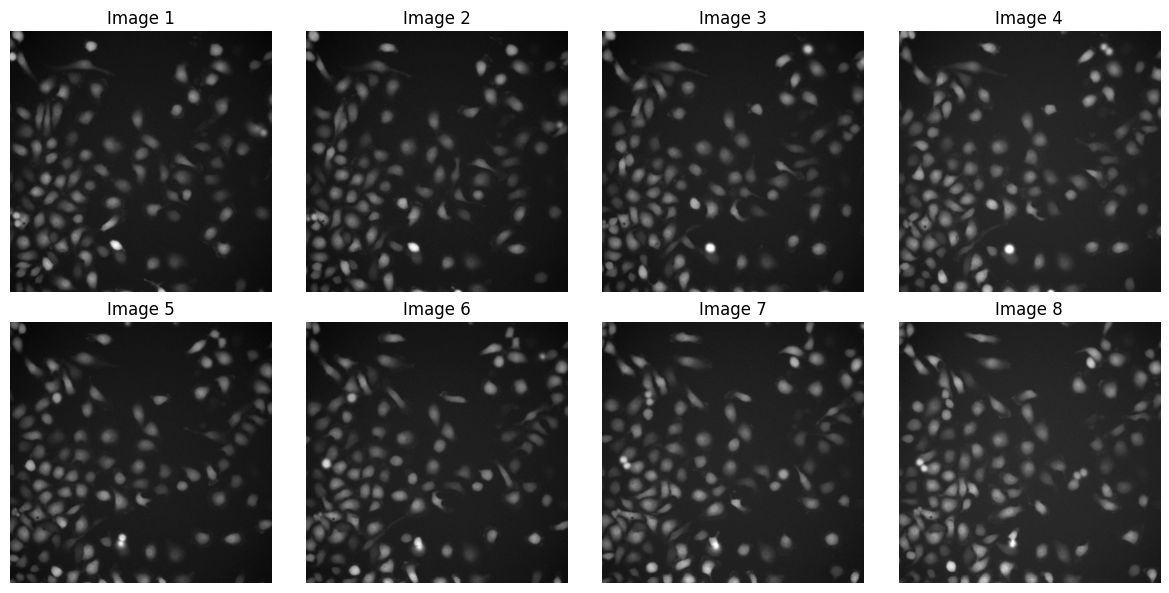

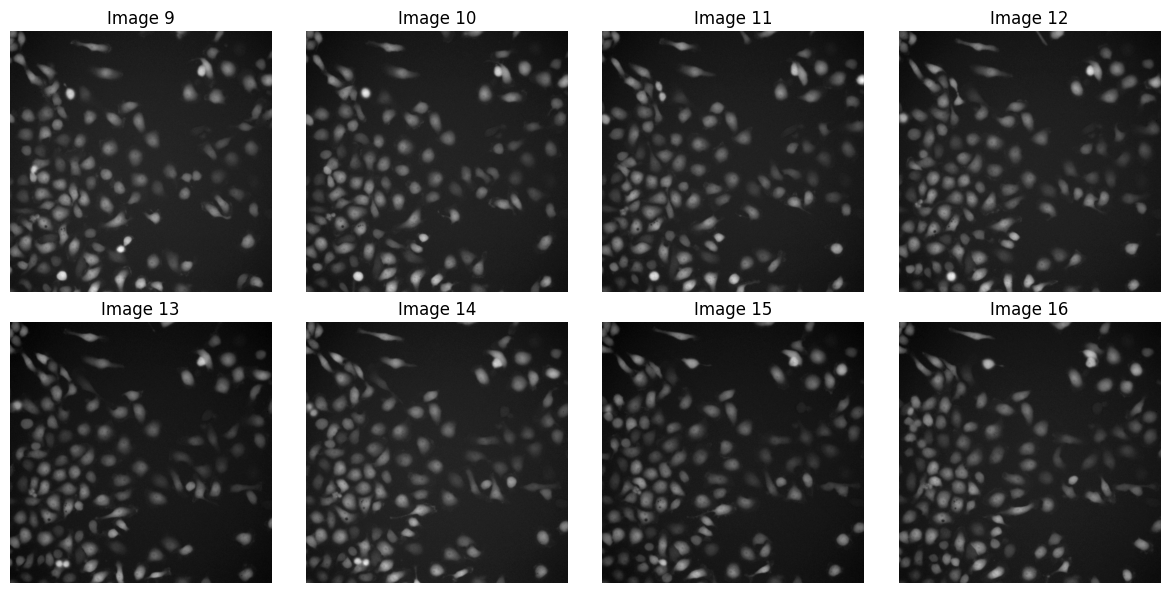

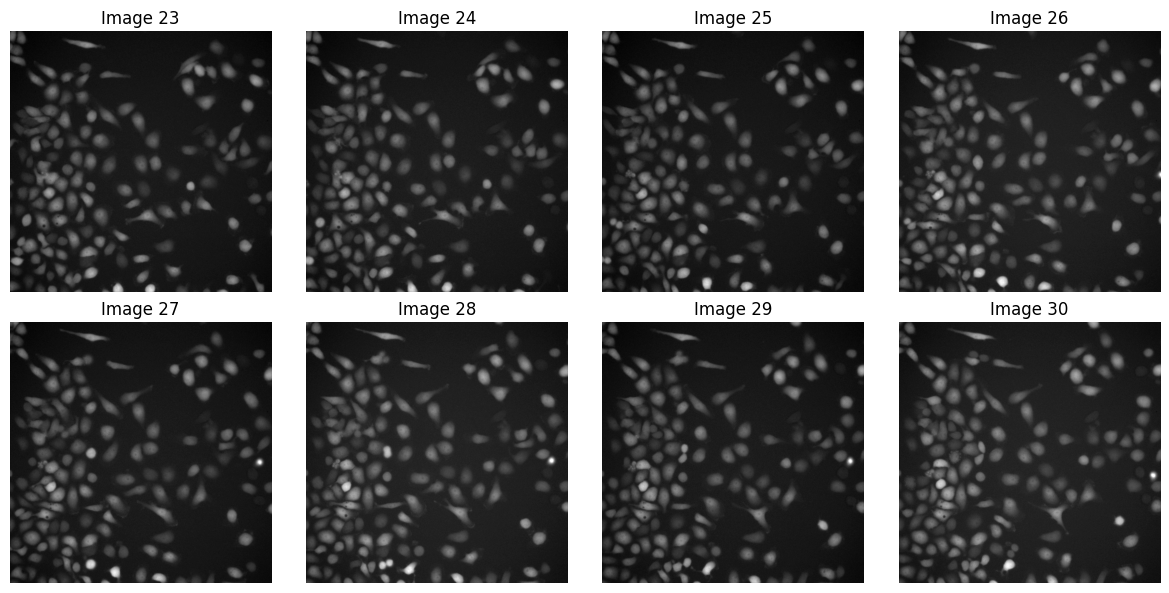

In [17]:
def segment_image(image):
    